# Bootstrap Sampling

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/master/11_resampling.ipynb) or
[click here to download it](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/11_resampling.ipynb).

In the previous chapter we used resampling to compute standard errors and confidence intervals, which quantify the variability in an estimate due to random sampling.

As one of the examples, we used data from the General Social Survey (GSS) to explore changes in support for gun control over time and to compute confidence intervals for the estimated proportions.

In this chapter, we'll use GSS data to estimate average income and the 10th percentile of income.
We'll see that the resampling method we used in the previous chapter works for the average income but not for the 10th percentile.

To solve this problem, we'll use another kind of resampling, called [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) or bootstrap sampling.

Then we'll use bootstrapping to compute sampling distributions and confidence intervals for other statistics, including the coefficient of correlation and the parameters of linear regression.

Finally, I'll point out a problem with bootstrap resampling when there are not enough different values in a dataset, and a way to solve it with KDE resampling.

## Estimating Average Income

As a first example, we'll use data from the General Social Survey to  estimate average family income.
The following cell loads the data, which I have stored in an HDF file.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    

In [2]:
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/gss_eda.hdf')

In [3]:
import pandas as pd

gss = pd.read_hdf('gss_eda.hdf', 'gss')
gss.head()

,YEAR,ID_,AGE,EDUC,SEX,GUNLAW,GRASS,REALINC
0,1972,1,23.0,16.0,2,1.0,NaN,18951.0
1,1972,2,70.0,10.0,1,1.0,NaN,24366.0
2,1972,3,48.0,12.0,2,1.0,NaN,24366.0
3,1972,4,27.0,17.0,2,1.0,NaN,30458.0
4,1972,5,61.0,12.0,2,1.0,NaN,50763.0


The column `REALINC` records family income, converted to 1986 dollars.
We can use `notna` and `sum` to count the number of valid responses.

In [4]:
n_realinc = gss['REALINC'].notna().sum()
n_realinc

58293

And we can compute the mean and standard deviation of the valid responses.

In [5]:
mean_realinc = gss['REALINC'].mean()
std_income = gss['REALINC'].std()
print(mean_realinc, std_income)

31742.563372816312 29526.067896235618


The average family income in this dataset is $31,742.  But notice that the standard deviation is almost equal to the mean.  That's because the distribution of income is long-tailed; many families have incomes below the mean, and there are a few families with incomes much higher than the mean.
Nevertheless, we can use this function from the previous chapter to simulate the sampling process.

In [6]:
import numpy as np

def simulate_sample_mean(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.mean()

`simulate_sample_mean` takes as parameters the sample size, `n`, and the presumed mean and standard deviation of income.

It generates a sample from a normal distribution with the given mean and standard deviation, and returns the mean of the sample.
If we call it once, we get a random value from the sampling distribution of the mean.

In [7]:
simulate_sample_mean(n_realinc, mean_realinc, std_income)

31893.30052036822

If we call it many times, we get a random sample from the sampling distribution.

In [8]:
t1 = [simulate_sample_mean(n_realinc, mean_realinc, std_income)
     for i in range(1000)]

I'll use the following function to summarize the sampling distribution.

In [9]:
def summarize(t, digits=2):
    table = pd.DataFrame(columns=['Estimate', 'SE', 'CI90'])
    est = np.mean(t).round(digits)
    SE = np.std(t).round(digits)
    CI90 = np.percentile(t, [5, 95]).round(digits)
    table.loc[''] = est, SE, CI90
    return table

In [10]:
summary1 = summarize(t1, digits=1)
summary1

,Estimate,SE,CI90
,31744.6,128.9,"[31537.8, 31958.5]"


The result is a table that shows the mean of the sampling distribution, the standard error, and a 90% confidence interval.
The mean of the sampling distribution is consistent with the mean of the data, which is $31,743.

In [11]:
mean_realinc

31742.563372816312

## Estimating Percentiles

The method in the previous section uses a normal distribution to simulate the sampling process.  In the previous chapter, when we estimated average height, this worked well because human heights are well modeled by a normal distribution.

But income is not.  We can see that by computing the CDF of a normal distribution with the same mean and standard as the income data.

In [12]:
from scipy.stats import norm

xs = np.linspace(-40000, 150000)
ys = norm(mean_realinc, std_income).cdf(xs)

And comparing it to the CDF of the data.

In [13]:
from empiricaldist import Cdf
import matplotlib.pyplot as plt
cdf_realinc = Cdf.from_seq(gss['REALINC'])

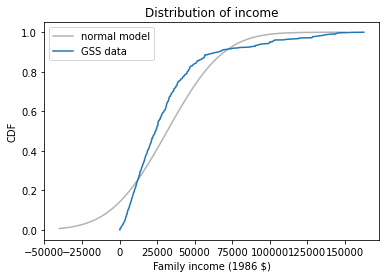

In [14]:
plt.plot(xs, ys, color='0.7', label='normal model')
cdf_realinc.plot(label='GSS data')

plt.xlabel('Family income (1986 $)')
plt.ylabel('CDF')
plt.title('Distribution of income')
plt.legend();

The normal distribution is not a good model for the data.  As we saw in the previous section, it is good enough to compute the sampling distribution of the mean.
But for other statistics, like percentiles, it is not good enough.

To demonstrate, here's a function that generates a sample from a normal distribution and returns the 10th percentile.

In [15]:
def simulate_sample_percentile(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return np.percentile(sample, 10)

We can use it to generate a sample from the sampling distribution of the 10th percentile.

In [16]:
t2 = [simulate_sample_percentile(n_realinc, mean_realinc, std_income)
      for i in range(1000)]

Here's a summary of the results.

In [17]:
summary2 = summarize(t2)
summary2

,Estimate,SE,CI90
,-6098.16,218.66,"[-6474.69, -5761.44]"


The mean of the sampling distribution is negative, which is not consistent with the actual 10th percentile of the data, which is $5631.

In [18]:
cdf_realinc.inverse(0.1)

array(5631.3)

In this example, resampling based on a normal model doesn't produce sensible results.
Fortunately there is a simple alternative that is more robust: bootstrapping.

## Bootstrapping

Bootstrapping is a kind of resampling, based on the framework we saw in the previous chapter:

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/resampling.png)

The idea is that we treat the sample as if it were the entire population, and simulate the sampling process by choosing random rows with replacement.
`DataFrame` provides a method called `sample` we can use to select a random sample of the rows.

In [19]:
bootstrapped = gss.sample(n=n_realinc, replace=True)
bootstrapped.shape

(58293, 8)

The argument `n=n_realinc` means that the bootstrapped sample has the same size as the original. 

`replace=True` means that sampling is done with replacement; that is, the same row can be chosen more than once.
To see how many times each row appears in the bootstrapped sample, we can use `value_counts` and the `_ID` column, which contains a unique identifier for each respondent. 

In [20]:
repeats = bootstrapped['ID_'].value_counts()
repeats.head()

272     46
1262    46
1116    46
208     44
192     44
Name: ID_, dtype: int64

Since some rows appear many times, other rows don't appear at all.  To see how many, we can use `set` subtraction to count the values of `ID_` that appear in the original dataset but not the bootstrapped sample.

In [21]:
unused = set(gss['ID_']) - set(bootstrapped['ID_'])
len(unused)

565

Now we can use bootstrapping to generate a sampling distribution.
For example, the following function takes a `DataFrame`, generates a bootstrapped sample, and returns the average income.

In [22]:
def bootstrap_mean(df, varname):
    bootstrapped = df.sample(n=len(df), replace=True)
    return bootstrapped[varname].mean()

If we run it many times, we get a sample from the sampling distribution of the mean.

In [23]:
t3 = [bootstrap_mean(gss, 'REALINC')
      for i in range(1001)]

Here's a summary of the results, compared to the results based on the normal model.

In [24]:
summary3 = summarize(t3)
table = pd.concat([summary1, summary3])
table.index=['normal model', 'bootstrapping']
table

,Estimate,SE,CI90
normal model,31744.6,128.90,"[31537.8, 31958.5]"
bootstrapping,31741.6,121.74,"[31551.65, 31944.21]"


The results from bootstrap sampling are consistent with the results based on the normal model.
Now let's see what happens when we estimate the 10th percentile.

The following function generates a bootstrapped sample and returns the 10th percentile.
Instead of `percentile` from Numpy, it uses `quantile` from Pandas, which drops `NaN` values.
The parameter of `quantile` is a probability between 0 and 1, rather than a percentage between 0 and 100.

In [25]:
def bootstrap_percentile(df):
    bootstrapped = df.sample(n=len(df), replace=True)
    return bootstrapped['REALINC'].quantile(0.1)

We can use it to generate a sample from the sampling distribution of the 10th percentile.

In [26]:
t4 = [bootstrap_percentile(gss)
      for i in range(1001)]

Here are the results along with the results based on the normal model.

In [27]:
summary4 = summarize(t4)
table = pd.concat([summary2, summary4])
table.index=['normal model', 'bootstrapping']
table

,Estimate,SE,CI90
normal model,-6098.16,218.66,"[-6474.69, -5761.44]"
bootstrapping,5647.85,83.76,"[5512.5, 5806.0]"


The mean of the sampling distribution is consistent with the 10th percentile of the data, which is $5631.
So the results from bootstrapping are more sensible than the results based on the normal model.

In [28]:
cdf_realinc.inverse(0.1)

array(5631.3)

In general, bootstrapping is robust; that is, it works well with many different distributions and many different statistics.
However, at the end of the chapter, we'll see one example where it fails.

## Bigger Data

As sample size increases, errors due to random sampling get smaller.
To demonstrate this effect, I'll use data from the Behavioral Risk Factor Surveillance System (BRFSS).

In previous chapters, we used BRFSS data to explore the relationship between height and weight, and the relationship between income and vegetable consumption.
In this section, we'll use it to estimate the average height for men in the United States.

First, let's read the 2019 data, which I have stored in an HDF file.

In [29]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/brfss.hdf')

In [30]:
import pandas as pd

brfss = pd.read_hdf('brfss.hdf', 'brfss')
brfss.shape

(418268, 11)

This dataset contains 418 268 rows, one for each respondent, and 11 columns, one for each variable I selected.
Here are the first few rows.

In [31]:
brfss.head()

,SEQNO,HTM4,WTKG3,_SEX,_AGEG5YR,_SMOKER3,_VEGESU1,_INCOMG,_EDUCAG,_LLCPWT,AGE
0,2019000001,157.0,69.85,2,13.0,3,114.0,2,1,135.304080,82.0
1,2019000002,163.0,48.99,2,11.0,4,121.0,3,3,1454.882220,72.0
2,2019000003,165.0,86.18,2,10.0,4,164.0,5,4,215.576852,67.0
3,2019000004,165.0,55.34,2,13.0,9,NaN,4,3,261.282838,82.0
4,2019000005,152.0,49.90,2,13.0,3,178.0,9,3,535.270103,82.0


Here's a Boolean `Series` that's `True` for male respondents.

In [32]:
male = (brfss['_SEX'] == 1)
male.sum()

189835

The column `HTM4` contains their heights in centimeters.

In [33]:
height = brfss['HTM4']

We can use `notna` and `sum` to count the number of rows with valid height data.

In [34]:
n_height = height[male].notna().sum()
n_height

182269

There are 182 269 male respondents with known heights.
Here is the mean and standard deviation of these values.

In [35]:
mean_height = height[male].mean()
std_height = height[male].std()
mean_height, std_height

(178.0768644146838, 7.966455313471575)

The average height for men in the U.S. is about 178.1 cm; the standard deviation is about 8 cm.
We can use bootstrapping to generate values from the sampling distribution of the mean.
To reduce computation time, I reduced the number of iterations to 201.

In [36]:
t5 = [bootstrap_mean(brfss[male], 'HTM4')
      for i in range(201)]

summarize(t5, digits=3)

,Estimate,SE,CI90
,178.075,0.017,"[178.048, 178.105]"


Because the sample size is so large, the standard error is small and the confidence interval is narrow.
This result suggests that our estimate is very precise, which is true in the sense that the error due to random sampling is small.

But there are other sources of error.  For example, the heights and weights in this dataset are based on self-reports, so they are vulnerable to [social desirability bias](https://en.wikipedia.org/wiki/Social-desirability_bias).  It's also possible that there are errors in recording the data.  In a previous year of the BRFSS, there are a suspicious number of heights recorded as 60 or 61 centimeters.  I suspect that many of them are six feet, or six feet and one inch, and something went wrong in the preparation of the data.

And that brings us to the first point of this example: 

> With large sample sizes, error due to random sampling is small, but with real-world data, that usually means that there are other sources of error that are bigger.  So we can't be sure that the estimate is accurate.

In fact, there is another source of error in this example that we have not taken into account: oversampling.

## Weighted Bootstrapping

By design, the BRFSS oversamples some groups; that is, people in some groups are more likely than others to appear in the sample.
If people in these groups are taller than others on average, or shorter, our estimated mean would not be accurate.

We encountered this issue in Chapter 7, where we used data from the National Survey of Family Growth (NSFG) to compute the average birth weight for babies in the United States.
In that example, we corrected for oversampling by computing a weighted mean.

In this example, we will use a different method, **weighted bootstrapping**, to estimate the mean and compute a confidence interval.

The BRFSS dataset includes a column, `_LLCPWT`, that contains sampling weights.
The sampling weight for each respondent is the number of people in the population they represent.
People in oversampled groups have lower sampling weights; people in undersampled groups have higher sampling weights.
Here's what the range of values looks like.

In [37]:
brfss['_LLCPWT'].describe()

count    418268.000000
mean        603.513276
std        1082.430311
min           1.016173
25%         111.160528
50%         272.869258
75%         654.211787
max       42066.730900
Name: _LLCPWT, dtype: float64

The lowest sampling weight is about 1; the largest is 42 066.
So that's a very wide range!

We can take these weights into account by passing them as an argument to `sample`.
That way, the probability that any row is selected is proportional to its sampling weight.

In [38]:
n = len(brfss)
weights = brfss['_LLCPWT']
bootstrapped = brfss.sample(n=n, replace=True, weights=weights)

As we saw with unweighted bootstrapping, the same row can appear more than once.
To see how many times, we can use `value_counts` and the `SEQNO` column, which contains a unique identifier for each respondent.

In [39]:
repeats = bootstrapped['SEQNO'].value_counts()
repeats.head()

2019000108    145
2019000096    115
2019000851    105
2019006167    105
2019000047    103
Name: SEQNO, dtype: int64

Some rows appear more than 100 times.  Most likely, these are the rows with the highest sampling rates, which correspond to people from undersampled groups.

To see how many rows don't appear at all, we can use `set` subtraction to count the values of `SEQNO` that appear in the original dataset but not the sample.

In [40]:
unused = set(brfss['SEQNO']) - set(bootstrapped['SEQNO'])
len(unused)

828

There are several hundred rows that don't appear in this sample, but they are not dropped altogether; when we repeat this process, they will appear in other samples.

We can use weighted bootstrapping to generate values from the sampling distribution of the mean.
The following function uses `sample` and the `_LLCPWT` column to generate a bootstrapped sample, then returns the average height.

In [41]:
def weighted_bootstrap_mean(df):
    n = len(df)
    weights = df['_LLCPWT']
    sample = df.sample(n=n, replace=True, weights=weights)
    return sample['HTM4'].mean()

I'll test this function with a `DataFrame` that contains only male respondents.
If we run it once, we get a random value from the sampling distribution of the weighted mean.

In [42]:
male_df = brfss[male]
weighted_bootstrap_mean(male_df)

177.6261509207366

If we run it many times, we get a random sample from the sampling distribution.

In [43]:
t6 = [weighted_bootstrap_mean(male_df) 
      for i in range(201)]

summarize(t6, digits=3)

,Estimate,SE,CI90
,177.642,0.02,"[177.606, 177.671]"


The mean of the sampling distribution estimates the average height for men in the U.S., corrected for oversampling.
If we compare it to the unweighted mean we computed, it is a little lower.

In [44]:
print(np.mean(t6), mean_height)

177.64150154229662 178.0768644146838


So it seems like people in the oversampled groups are taller than others, on average, by enough to bring the unweighted mean up by about half a centimeter.

The difference between the weighted and unweighted means is bigger than the width of the confidence interval.
So in this example the error if we fail to correct for oversampling is bigger than variability due to random sampling.

## Correlation and Regression

Bootstrap resampling can be used to estimate other statistics and their sampling distributions.
For example, in Chapter 9 we computed the correlation between height and weight, like this:

In [45]:
columns = ['HTM4', 'WTKG3']
subset = brfss[columns]
subset.corr()

,HTM4,WTKG3
HTM4,1.000000,0.477151
WTKG3,0.477151,1.000000


That correlation does not take into account oversampling.
We can correct it with this function, which generates a weighted bootstrapped sample and uses it to compute the correlation of height and weight.

In [46]:
def weighted_bootstrap_corr(df):
    n = len(df)
    weights = df['_LLCPWT']
    sample = df.sample(n=n, replace=True, weights=weights)
    corr = sample[columns].corr()
    return corr.iloc[0, 1]

**Exercise:** Use this function to draw 101 values from the sampling distribution of the correlation between height and weight.
What is the mean of these values?  Is it substantially different from the correlation we computed without correcting for oversampling?
Compute the standard error and 90% confidence interval for the estimated correlation.

In [47]:
# Solution

t7 = [weighted_bootstrap_corr(brfss)
      for i in range(101)]

summarize(t7, digits=5)

,Estimate,SE,CI90
,0.46503,0.00152,"[0.46255, 0.46712]"


In [48]:
# Solution

# The estimated correlation with weighted bootstrapping is
# slightly smaller, but the different is not enough to matter 
# in practice.

# But the error due to oversampling, although small,
# is bigger than variability due to random sampling,
# which is small because the sample size is so large.

**Exercise:** In Chapter 9 we also computed the slope of the regression line for weight as a function of height.
Here's the result with with 2019 data.

In [49]:
from scipy.stats import linregress

subset = brfss.dropna(subset=['WTKG3', 'HTM4'])
res = linregress(subset['HTM4'], subset['WTKG3'])
res.slope

0.932929241334935

The estimated slope is 0.93 kg/cm, which means that we expect someone 1 cm taller than average to be about 0.93 kg heavier than average.

Write a function called `weighted_bootstrap_slope` that takes a `DataFrame`, generates a weighted bootstrapped sample, runs `linregress` with height and weight, and returns the slope of the regression line.

Run it 101 times and collect the results.  Use the sampling distribution to compute the mean of the slope estimates, standard error, and a 90% confidence interval.

In [50]:
# Solution

def weighted_bootstrap_slope(df):
    n = len(df)
    weights = df['_LLCPWT']
    sample = df.sample(n=n, replace=True, weights=weights)
    subset = sample.dropna(subset=['WTKG3', 'HTM4'])
    res = linregress(subset['HTM4'], subset['WTKG3'])
    return res.slope

In [51]:
# Solution

t8 = [weighted_bootstrap_slope(brfss)
      for i in range(101)]

summarize(t8, digits=5)

,Estimate,SE,CI90
,0.89777,0.00341,"[0.89167, 0.90244]"


## Limitations of Bootstrapping

One limitation of bootstrapping is that it can be computationally expensive.
With small datasets, it is usually fast enough that we can generate 1000 values from the sampling distribution, which means that we can compute standard errors and confidence intervals precisely.
With larger datasets, we can cut the computation time by generating fewer values.
With 100-200 values, the standard errors we get are usually precise enough, but the bounds of the confidence intervals might be noisier.

The other limitation, which can be more problematic, is that bootstrap sampling does not work well with datasets that contain a small number of different values.
To demonstrate, I'll select data from the GSS for one year, 2018:

In [52]:
gss2018 = gss[gss['YEAR']==2018]

And I'll use bootstrapping to generate values from the sampling distribution of income.

In [53]:
t9 = [bootstrap_percentile(gss2018)
      for i in range(1001)]

Here are the results.

In [54]:
summary9 = summarize(t9)
summary9

,Estimate,SE,CI90
,5150.02,217.76,"[5107.5, 5107.5]"


The mean of the sampling distribution and the standard error look plausible at first glance, but the width of the confidence interval is 0, which suggests that something has gone wrong!

The problem is that `REALINC` is not really a numerical variable; it is a categorical variable in disguise.
Using `value_counts`, we can see that there are only 26 distinct values in this column.

In [55]:
len(gss2018['REALINC'].value_counts())

26

The reason is that the GSS does not ask respondents to report their incomes.
Instead, it gives them a list of ranges and asks them to pick the range their income falls in. 
The ranges are described in the documentation of the related variable [`INCOME`](https://gssdataexplorer.norc.org/variables/104/vshow).

Then GSS analysts compute the midpoint of each range and convert to 1986 dollars by adjusting for inflation.
Details of the methodology are in [this paper](https://gss.norc.org/Documents/reports/methodological-reports/MR101%20Getting%20the%20Most%20Out%20of%20the%20GSS%20Income%20Measures.pdf)

As a result, there are only 26 distinct values in `REALINC`.
When we generate a bootstrapped sample and compute the 10th percentile, we get a small subset of them.  Here are the values that appear in our sample: 

In [56]:
pd.Series(t9).value_counts().sort_index()

4086.0      1
5107.5    960
5675.0      2
5902.0      1
6015.5      1
6129.0      1
6242.5     35
dtype: int64

There are only 5 different values, and one of them appears more than 95% of the time.
When we compute a 90% confidence interval, this value is both the 5th and the 95th percentile.

In general, bootstrapping works well for many distributions and many statistics.
But the one thing it cannot handle is lack of diversity in the data.

However, even this problem can be solved.
The fundamental cause is that the data have been discretized excessively, so the solution is to smooth it.
Jittering is one option.  Another is to use kernel density estimation (KDE).

## Resampling with KDE

We have used KDE several times to estimate and plot a probability density based on a sample.
We can also use it to smooth data that have been discretized.

In Chapter 7 we saw that the distribution of income is well modeled by a lognormal distribution, so if we take the log of income, it is well modeled by a normal distribution.
Here are the logarithms of the income data.

In [57]:
log_realinc = np.log10(gss2018['REALINC'].dropna())

And here's what the estimated density looks like.

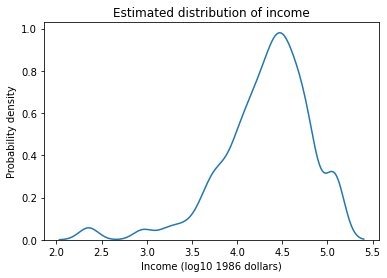

In [58]:
import seaborn as sns

sns.kdeplot(log_realinc)

plt.xlabel('Income (log10 1986 dollars)')
plt.ylabel('Probability density')
plt.title('Estimated distribution of income');

To draw samples from this distribution, we'll use a Scipy function called `gaussian_kde`, which takes the data and returns an object that represents the estimated density.


In [59]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(log_realinc)

`kde` provides a method called `resample` that draws random values from the estimated density.
As we've done in previous examples, we'll generate a resampled dataset with the same size as the original. 

In [60]:
n = gss2018['REALINC'].notna().sum()
n

2152

Now we can draw a sample, compute the 10th percentile, and convert from a logarithm to a dollar value.

In [61]:
sample = kde.resample(n)
10 ** np.percentile(sample, 10)

5624.877370535091

The result is a random value from the sampling distribution of the 10th percentile.
The following function encapsulates these steps.

In [62]:
def resample_kde_percentile(kde):
    sample = kde.resample(kde.n)
    return 10 ** np.percentile(sample, 10)

Now we can generate a sample from the sampling distribution.

In [63]:
t10 = [resample_kde_percentile(kde)
       for i in range(1000)]

summary10 = summarize(t10)

The following table compares the results with KDE resampling to the previous result with bootstrapping.

In [64]:
table = pd.concat([summary9, summary10])
table.index=['bootstrapping', 'KDE resampling']
table

,Estimate,SE,CI90
bootstrapping,5150.02,217.76,"[5107.5, 5107.5]"
KDE resampling,5092.76,264.18,"[4666.12, 5538.53]"


The means and standard errors are about the same with either method.  The difference is that the confidence interval we get from KDE resampling is much more reasonable.

## Summary

There are ten examples in this chapter so far; let's review them:

1. First we used resampling based on a normal model to estimate average family income in the GSS and compute a confidence interval.

2. Then we used the same method to estimate the 10th percentile of income, and we found that the width of the confidence interval was 0.  The problem is that the normal model does not fit the distribution of income.  

3. To solve this problem, we switched to bootstrap sampling.  First we estimated average family income and confirmed that the results are consistent with the results based on the normal model.

4. Then we used bootstrapping to estimate the 10th percentile of income.  The results are much more plausible.

5. Next we used data from the BRFSS to estimate the average height of men in the U.S.  Since this dataset is large, the confidence interval is very small.  That means that the estimate is precise, in the sense that variability due to random sampling is small, but we don't know whether it is accurate, because there are other possible sources of error.

6. One of those sources of error is oversampling; that is, some people are more likely to appear in the sample than others.  In the BFRSS, each respondent has a sampling weight that indicates how many people in the population they represent.  We used these weighted to do weighted bootstrapping, and found that the error due to oversampling is larger than the variability due to random sampling.

7. In one exercise you used weighted bootstrapping to estimate the correlation of height and weight and compute a confidence interval.

8. In another exercise you estimated the slope of a regression line and computed a confidence interval.

9. Finally, I demonstrated a problem with bootstrap sampling when the dataset has only a few different values,

10. And presented a solution using KDE to smooth the data and draw samples from an estimated distribution.

In the exercise below, you can work on one more example.

**Exercise:** In Chapter 10 we used logistic regression to model support for legalizing marijuana as a function of age, sex, and education level.
Going back to that example, let's explore changes in support over time and generate predictions for the next decade.

To prepare the data for logistic regression, we have to recode the `GRASS` column so `1` means in favor of legalization and `0` means not in favor.

In [65]:
gss['GRASS'].replace(2, 0, inplace=True)
gss['GRASS'].value_counts()

0.0    25662
1.0    11884
Name: GRASS, dtype: int64

As explanatory variables we'll use `YEAR` and `YEAR` squared, which I'll store in a column called `YEAR2`.

In [66]:
gss['YEAR2'] = gss['YEAR'] ** 2

Now we can run the model like this:

In [67]:
import statsmodels.formula.api as smf

formula = 'GRASS ~ YEAR + YEAR2'
results = smf.logit(formula, data=gss).fit(disp=False)

/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


To generate predictions, I'll create a `DataFrame` with a range of values of `YEAR` up to 2030, and corresponding values of `YEAR2`.

In [68]:
years = np.linspace(1972, 2030)
df_pred = pd.DataFrame()
df_pred['YEAR'] = years
df_pred['YEAR2'] = df_pred['YEAR']**2

pred = results.predict(df_pred)

I'll use `groupby` to compute the fraction of respondents in favor of legalization during each year.

In [69]:
grass_by_year = gss.groupby('YEAR')['GRASS'].mean()

The following function plots the data and decorates the axes.

In [70]:
def plot_data():
    grass_by_year.plot(style='o', alpha=0.5, label='data')
    plt.xlabel('Year')
    plt.ylabel('Fraction in favor')
    plt.title('Support for legalization of marijuana')
    plt.legend();

Here's what the predictions look like, plotted along with the data.

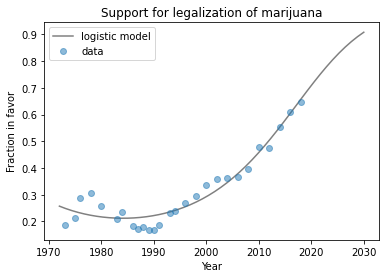

In [71]:
plt.plot(years, pred, label='logistic model', color='gray')
plot_data()

The model fits past data reasonably well and makes plausible predictions for the next decade, although we can never be sure that trends like this will continue.

This way of representing the results could be misleading because it does not show our uncertainty about the predictions.
Random sampling is just one source of uncertainty among many, and for this kind of prediction it is certainly not the biggest.
But it is the easiest to quantify, so let's do it, if only as an exercise.

Write a function called `bootstrap_regression_line` that takes a `DataFrame` as a parameter, uses `sample` to resample the rows, runs the logistic regression model, generates predictions for the rows in `df_pred`, and returns the predictions.

Call this function 101 times and save the results as a list of `Series` objects.
To visualize the results, you have two options:

1. Loop through the list and plot each prediction using a gray line with a low value of `alpha`.  The overlapping lines will form a region showing the range of uncertainty over time.

2. Pass the list of `Series` to `np.percentile` with the argument `axis=0` to compute the 5th and 95th percentile in each column.  Plot these percentiles as two lines, or use `plt.fill_between` to plot a shaded region between them.

In [72]:
# Solution

def bootstrap_regression_line(df):
    n = len(df)
    sample = df.sample(n=n, replace=True)
    results = smf.logit(formula, data=sample).fit(disp=False)
    pred = results.predict(df_pred)
    return pred

In [73]:
# Solution

t11 = [bootstrap_regression_line(gss)
       for i in range(101)]

/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: Converg

/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: Converg

/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/downey/anaconda3/envs/ElementsOfDataScience/lib/python3.7/site-packages/statsmodels/base/model.py:568: Converg

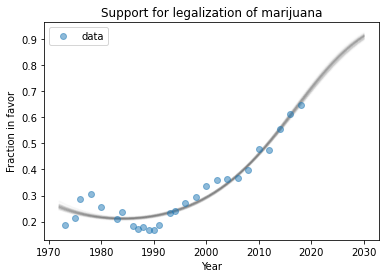

In [74]:
# Solution

for pred in t11:
    plt.plot(years, pred, color='gray', alpha=0.02)
    
plot_data()

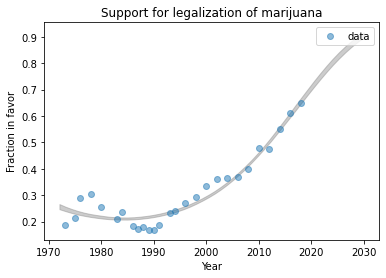

In [75]:
# Solution

low, high = np.percentile(t11, [5, 95], axis=0)
plt.fill_between(years, low, high, 
                 color='gray', alpha=0.4)
plot_data()